In [1]:
!pip install torch torchvision opencv-python matplotlib


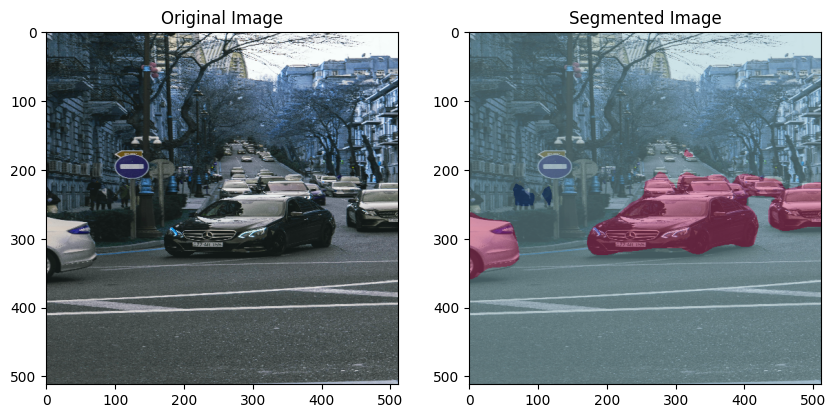

In [5]:
import torch
import torchvision
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Load a pre-trained DeepLabV3 model
model = torchvision.models.segmentation.deeplabv3_resnet101(pretrained=True)
model.eval()  # Set the model to evaluation mode

# Preprocess the image
def preprocess(image_path):
    # Load and convert the image to RGB (OpenCV loads images in BGR format)
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Resize the image to 512x512 for the model
    image_resized = cv2.resize(image_rgb, (512, 512))

    # Convert the image to a tensor and normalize as required by the model
    preprocess_transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Apply preprocessing and add a batch dimension (1, C, H, W)
    input_tensor = preprocess_transform(image_resized).unsqueeze(0)
    return input_tensor, image_resized

# Perform segmentation and post-process the output
def segment_image(model, input_tensor):
    with torch.no_grad():
        # Get the model output
        output = model(input_tensor)['out'][0]
        # Get the class with the highest score for each pixel
        output_predictions = output.argmax(0).byte().cpu().numpy()
    return output_predictions

# Function to overlay the segmentation mask on the original image
def overlay_segmentation_mask(image, mask):
    # Create a color map for different classes (just using random colors for visualization)
    colormap = np.random.randint(0, 255, (21, 3), dtype=np.uint8)  # 21 classes in the DeepLab model

    # Map the mask to colors using the colormap
    colored_mask = colormap[mask]

    # Blend the original image and the colored mask
    blended = cv2.addWeighted(image, 0.6, colored_mask, 0.4, 0)
    return blended

# Load the image and preprocess it
image_path = '/content/pexels-parviz-hajizada-688154920-20495139.jpg'  # Replace with your image path
input_tensor, image_resized = preprocess(image_path)

# Apply the segmentation model to the image
mask = segment_image(model, input_tensor)

# Overlay the segmentation mask on the original image
result_image = overlay_segmentation_mask(image_resized, mask)

# Display the result
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image_resized, cv2.COLOR_BGR2RGB))
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
plt.title("Segmented Image")

plt.show()
